In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from typing import List, Tuple
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

In [2]:
# Constants
NUM_NODES = 10000
AVERAGE_DEGREE = 6
INFECTION_PROBABILITY = 0.02
RECOVERY_TIME = 14
INCUBATION_PERIOD = 5
VACCINATION_RATE = 0.5
LOCKDOWN_START = 120
LOCKDOWN_DURATION = 60
LOCKDOWN_EFFECTIVENESS = 0.5
SEASONALITY_FACTOR = [1.0 if 90 <= day % 365 <= 270 else 0.8 for day in range(365)]

In [3]:
def create_initial_graph(num_nodes: int, average_degree: int) -> nx.Graph:
    """
    Creates an initial connected graph with weighted edges.

    Args:
        num_nodes (int): Number of nodes in the graph.
        average_degree (int): Average degree of nodes in the graph.

    Returns:
        nx.Graph: A connected graph with weighted edges.
    """
    graph = nx.barabasi_albert_graph(num_nodes, average_degree)

    # Assign random weights to edges
    for u, v in graph.edges():
        graph[u][v]['weight'] = random.uniform(0.1, 1.0)

    # Ensure the graph is connected
    if not nx.is_connected(graph):
        largest_cc = max(nx.connected_components(graph), key=len)
        graph = graph.subgraph(largest_cc).copy()

    return graph


def initialize_nodes(graph: nx.Graph, initial_infected: int = 10) -> None:
    """
    Initializes the nodes with their states (Susceptible, Infected).

    Args:
        graph (nx.Graph): The graph representing the network.
        initial_infected (int): Number of initially infected individuals.
    """
    for node in graph.nodes():
        graph.nodes[node]['state'] = 'S'  # Susceptible
        graph.nodes[node]['days_infected'] = 0

    infected_nodes = random.sample(list(graph.nodes()), k=initial_infected)
    for node in infected_nodes:
        graph.nodes[node]['state'] = 'I'  # Infected


def simulate(graph: nx.Graph, days: int, scenario: str = "base") -> Tuple[List[int], List[int], List[int]]:
    """
    Simulates the spread of infection over a given number of days.

    Args:
        graph (nx.Graph): The network graph.
        days (int): Number of days to simulate.
        scenario (str): The simulation scenario ('base', 'vaccination', 'lockdown').

    Returns:
        Tuple[List[int], List[int], List[int]]: Daily counts of susceptible, infected, and recovered individuals.
    """
    daily_susceptible = []
    daily_infected = []
    daily_recovered = []

    # Apply vaccination if the scenario is vaccination
    if scenario == "vaccination":
        vaccinated_nodes = random.sample(list(graph.nodes()), k=int(VACCINATION_RATE * NUM_NODES))
        for node in vaccinated_nodes:
            if graph.nodes[node]['state'] == 'S':
                graph.nodes[node]['state'] = 'V'  # Vaccinated

    for day in range(days):
        new_infected = []
        for node in graph.nodes():
            if graph.nodes[node]['state'] == 'I':
                graph.nodes[node]['days_infected'] += 1

                # Recovery
                if graph.nodes[node]['days_infected'] >= RECOVERY_TIME:
                    graph.nodes[node]['state'] = 'R'  # Recovered
                # Spread infection
                elif graph.nodes[node]['days_infected'] >= INCUBATION_PERIOD:
                    for neighbor in graph.neighbors(node):
                        if graph.nodes[neighbor]['state'] == 'S':
                            weight = graph[node][neighbor]['weight']
                            seasonality = SEASONALITY_FACTOR[day % 365]
                            lockdown = (LOCKDOWN_EFFECTIVENESS if scenario == "lockdown" and
                                        LOCKDOWN_START <= day < LOCKDOWN_START + LOCKDOWN_DURATION else 1.0)
                            if random.uniform(0, 1) < INFECTION_PROBABILITY * weight * seasonality * lockdown:
                                new_infected.append(neighbor)

        for node in new_infected:
            graph.nodes[node]['state'] = 'I'

        # Record daily counts
        susceptible_count = sum(1 for node in graph.nodes() if graph.nodes[node]['state'] == 'S')
        infected_count = sum(1 for node in graph.nodes() if graph.nodes[node]['state'] == 'I')
        recovered_count = sum(1 for node in graph.nodes() if graph.nodes[node]['state'] == 'R')

        daily_susceptible.append(susceptible_count)
        daily_infected.append(infected_count)
        daily_recovered.append(recovered_count)

    return daily_susceptible, daily_infected, daily_recovered


def plot_degree_distribution(graph: nx.Graph) -> None:
    """Plots the degree distribution of the graph."""
    degrees = [degree for _, degree in graph.degree()]
    plt.hist(degrees, bins=50, color='blue', alpha=0.7, edgecolor='black')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    print(f"Average Degree: {np.mean(degrees):.2f}")
    print(f"Max Degree: {np.max(degrees)}")
    print(f"Min Degree: {np.min(degrees)}")
    print(f"Number of Hubs: {sum(1 for degree in degrees if degree > 2 * np.mean(degrees))}")


def plot_simulation_results(scenarios: List[Tuple[str, List[int]]], title: str, ylabel: str) -> None:
    """Plots simulation results for multiple scenarios."""
    plt.figure(figsize=(10, 6))
    for label, data in scenarios:
        plt.plot(data, label=label)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

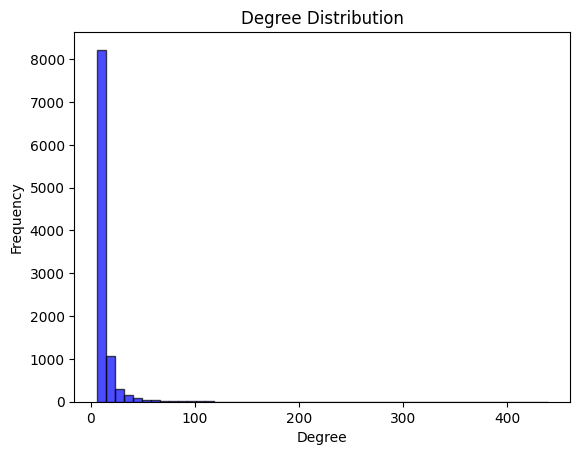

Average Degree: 11.99
Max Degree: 439
Min Degree: 6
Number of Hubs: 706


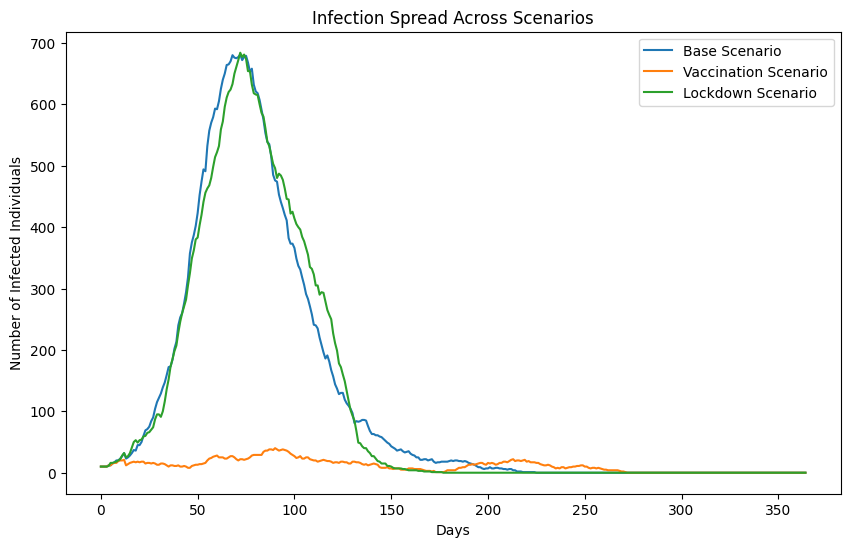

Base Scenario: Peak Infected = 681 on Day 72
Vaccination Scenario: Peak Infected = 40 on Day 90
Lockdown Scenario: Peak Infected = 684 on Day 72


In [4]:
# Create and initialize the graph
initial_graph = create_initial_graph(NUM_NODES, AVERAGE_DEGREE)
initialize_nodes(initial_graph)

# Plot degree distribution
plot_degree_distribution(initial_graph)

# Simulate scenarios
base_results = simulate(initial_graph.copy(), 365, scenario="base")
vaccination_results = simulate(initial_graph.copy(), 365, scenario="vaccination")
lockdown_results = simulate(initial_graph.copy(), 365, scenario="lockdown")

# Plot results
plot_simulation_results([
    ("Base Scenario", base_results[1]),
    ("Vaccination Scenario", vaccination_results[1]),
    ("Lockdown Scenario", lockdown_results[1])
], title="Infection Spread Across Scenarios", ylabel="Number of Infected Individuals")

# Print peak infection statistics
for scenario_name, results in zip(["Base", "Vaccination", "Lockdown"], [base_results, vaccination_results, lockdown_results]):
    peak_infected = max(results[1])
    peak_day = results[1].index(peak_infected)
    print(f"{scenario_name} Scenario: Peak Infected = {peak_infected} on Day {peak_day}")

In [5]:
# Constants for the simulation
NUM_NODES = 10_000
INITIAL_INFECTED_COUNT = 10
SIMULATION_DAYS = 365
BASIC_REPRODUCTION_NUMBER = 2.5
IMMUNITY_LOSS_RATE = 0.01  # Per day
VACCINATION_RATE = 0.002  # Per day in vaccinated scenario
QUARANTINE_EFFECTIVENESS = 0.5
SEASONALITY_FACTOR = 1.2

# States
SUSCEPTIBLE = 0
INFECTED = 1
RECOVERED = 2

In [6]:
def create_contact_network(num_nodes: int, avg_degree: int) -> nx.Graph:
    """Creates a Barabasi-Albert graph to simulate a contact network.

    Args:
        num_nodes (int): Number of nodes in the network.
        avg_degree (int): Average degree of the nodes.

    Returns:
        nx.Graph: A contact network with edge weights.
    """
    graph = nx.barabasi_albert_graph(num_nodes, avg_degree)
    weights = np.random.uniform(0.1, 1.0, size=graph.number_of_edges())
    nx.set_edge_attributes(graph, {e: {'weight': w} for e, w in zip(graph.edges, weights)})
    return graph

def visualize_degree_distribution(graph: nx.Graph) -> None:
    """Visualizes the degree distribution of a graph.

    Args:
        graph (nx.Graph): The contact network.
    """
    degrees = [degree for _, degree in graph.degree()]
    print(f"Average Degree: {np.mean(degrees):.2f}")
    print(f"Max Degree: {np.max(degrees)}")
    print(f"Min Degree: {np.min(degrees)}")

    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=50, color='skyblue', edgecolor='black')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

def initialize_states(num_nodes: int, initial_infected_count: int) -> np.ndarray:
    """Initializes the states of the population.

    Args:
        num_nodes (int): Total number of nodes in the network.
        initial_infected_count (int): Number of initially infected nodes.

    Returns:
        np.ndarray: Array representing the states of all nodes.
    """
    states = np.full(num_nodes, SUSCEPTIBLE)
    initial_infected = np.random.choice(range(num_nodes), size=initial_infected_count, replace=False)
    states[initial_infected] = INFECTED
    print(f"Initial Infected Nodes: {initial_infected}")
    return states

def simulate_day(
    graph: nx.Graph,
    states: np.ndarray,
    beta: float,
    gamma: float,
    vaccination_rate: float = 0.0,
    quarantine_factor: float = 1.0
) -> np.ndarray:
    """Simulates one day of disease spread.

    Args:
        graph (nx.Graph): The contact network.
        states (np.ndarray): Current states of all nodes.
        beta (float): Infection probability multiplier.
        gamma (float): Recovery probability.
        vaccination_rate (float, optional): Daily vaccination rate. Defaults to 0.0.
        quarantine_factor (float, optional): Factor reducing transmission due to quarantine. Defaults to 1.0.

    Returns:
        np.ndarray: Updated states of all nodes.
    """
    new_states = states.copy()

    for node in graph.nodes:
        if states[node] == INFECTED:
            for neighbor in graph.neighbors(node):
                if states[neighbor] == SUSCEPTIBLE:
                    transmission_prob = graph[node][neighbor]['weight'] * beta * quarantine_factor
                    if bernoulli.rvs(transmission_prob):
                        new_states[neighbor] = INFECTED
            if bernoulli.rvs(gamma):
                new_states[node] = RECOVERED

        elif states[node] == SUSCEPTIBLE:
            if bernoulli.rvs(vaccination_rate):
                new_states[node] = RECOVERED

    return new_states

def run_simulation(
    graph: nx.Graph,
    days: int,
    beta: float,
    gamma: float,
    vaccination_rate: float = 0.0,
    quarantine_factor: float = 1.0
) -> dict:
    """Runs the disease spread simulation for a specified number of days.

    Args:
        graph (nx.Graph): The contact network.
        days (int): Number of days to simulate.
        beta (float): Infection probability multiplier.
        gamma (float): Recovery probability.
        vaccination_rate (float, optional): Daily vaccination rate. Defaults to 0.0.
        quarantine_factor (float, optional): Factor reducing transmission due to quarantine. Defaults to 1.0.

    Returns:
        dict: Daily counts of susceptible, infected, and recovered individuals.
    """
    daily_counts = {'susceptible': [], 'infected': [], 'recovered': []}
    global states

    for day in range(days):
        states = simulate_day(graph, states, beta, gamma, vaccination_rate, quarantine_factor)
        daily_counts['susceptible'].append(np.sum(states == SUSCEPTIBLE))
        daily_counts['infected'].append(np.sum(states == INFECTED))
        daily_counts['recovered'].append(np.sum(states == RECOVERED))

    return daily_counts

def plot_simulation_results(scenarios: list, labels: list) -> None:
    """Plots the results of multiple scenarios for comparison.

    Args:
        scenarios (list): List of simulation results.
        labels (list): Labels for each scenario.
    """
    for results, label in zip(scenarios, labels):
        plt.figure(figsize=(12, 6))
        plt.plot(results['susceptible'], label='Susceptible')
        plt.plot(results['infected'], label='Infected')
        plt.plot(results['recovered'], label='Recovered')
        plt.title(f"Disease Spread: {label}")
        plt.xlabel("Days")
        plt.ylabel("Population Count")
        plt.legend()
        plt.grid()
        plt.show()

Average Degree: 9.99
Max Degree: 433
Min Degree: 5


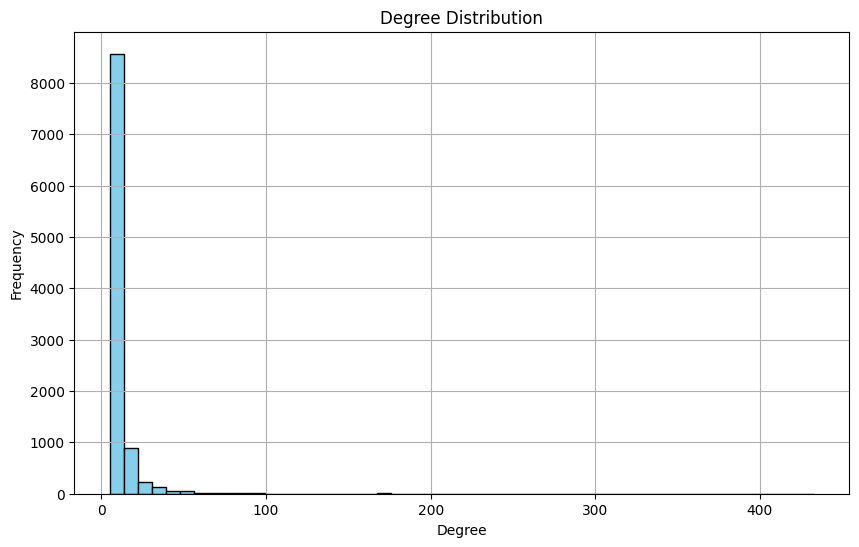

Initial Infected Nodes: [7032 4364 1824 4185 1870 5322 1706 4077 6552 1276]
Initial Infected Nodes: [8472 5948    3 7839  726 1308 6152 9025 1733 7775]
Initial Infected Nodes: [8622  385 1808 2320  735 9839 3287 7343 8174 9773]


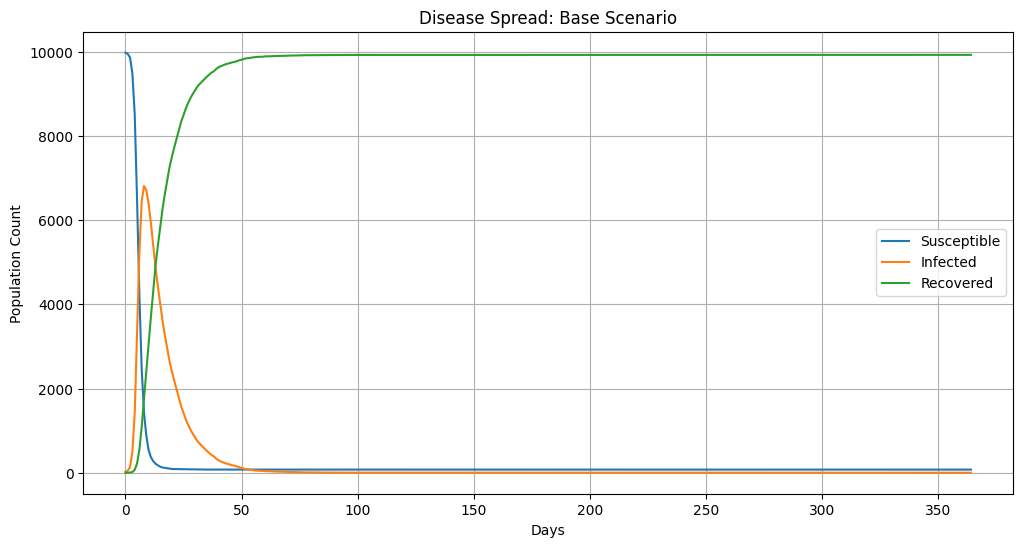

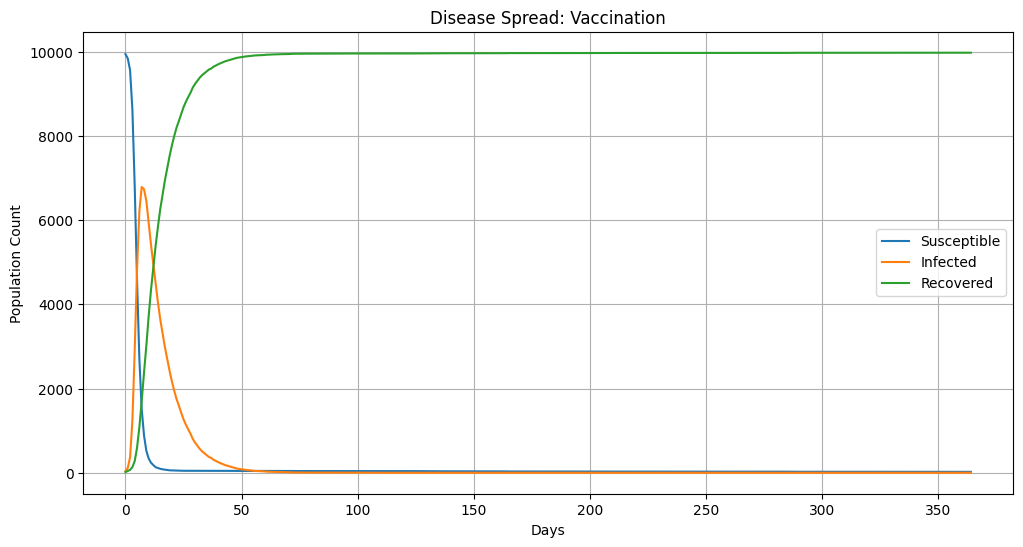

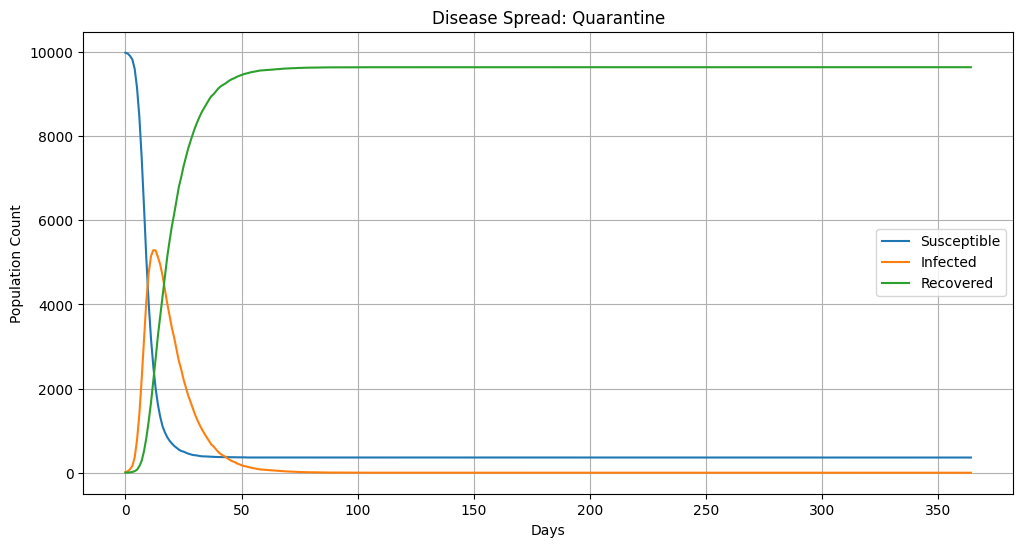

Base Scenario - Peak Infected: 6813, Final Recovered: 9926
Vaccination - Peak Infected: 6788, Final Recovered: 9979
Quarantine - Peak Infected: 5290, Final Recovered: 9639


In [7]:
contact_network = create_contact_network(NUM_NODES, avg_degree=5)
visualize_degree_distribution(contact_network)

beta = BASIC_REPRODUCTION_NUMBER / (np.mean([d for _, d in contact_network.degree()]) or 1)
gamma = 0.1  # Recovery rate

# Base scenario
global states
states = initialize_states(NUM_NODES, INITIAL_INFECTED_COUNT)
base_results = run_simulation(contact_network, SIMULATION_DAYS, beta, gamma)

# Vaccination scenario
states = initialize_states(NUM_NODES, INITIAL_INFECTED_COUNT)
vaccination_results = run_simulation(contact_network, SIMULATION_DAYS, beta, gamma, vaccination_rate=VACCINATION_RATE)

# Quarantine scenario
states = initialize_states(NUM_NODES, INITIAL_INFECTED_COUNT)
quarantine_results = run_simulation(contact_network, SIMULATION_DAYS, beta, gamma, quarantine_factor=QUARANTINE_EFFECTIVENESS)

# Plot results
plot_simulation_results(
    [base_results, vaccination_results, quarantine_results],
    ["Base Scenario", "Vaccination", "Quarantine"]
)

# Print conclusions
for label, results in zip(["Base Scenario", "Vaccination", "Quarantine"], [base_results, vaccination_results, quarantine_results]):
    peak_infected = max(results['infected'])
    final_recovered = results['recovered'][-1]
    print(f"{label} - Peak Infected: {peak_infected}, Final Recovered: {final_recovered}")